## DA 623 Term Project:



*   **Topic:**  Compare and contrast PCA and auto-encoder,using  MNIST dataset for demonstration(61)
*   **Submitted By:** Soham Karak, 200102107
*   **Supervisor**: Dr. Neeraj Sharma
*   **Date of Submission**: 2nd March 2024

  **Disclaimer:**
  
  I agree that the tutorial is my own work. Any material and help taken is referenced and acknowledged in the ReadMe file.










# Introduction

In this tutorial, we will explore two powerful dimensionality reduction techniques: **Principal Component Analysis (PCA)** and **autoencoders**. These techniques play a crucial role in data compression and data analysis by transforming high-dimensional data into a lower-dimensional representation while preserving important information.

## What is PCA?

***Principal Component Analysis (PCA)*** is a linear transformation that finds the directions of maximum variance in the data and projects the data onto a lower-dimensional space. These directions, known as principal components, are orthogonal to each other. PCA can be seen as a way of compressing the data by discarding the components with low variance and retaining the most important ones. It is often used for data visualization, feature extraction, and noise reduction. Mathematically, PCA involves computing the eigenvectors and eigenvalues of the covariance matrix of the data and selecting the top-k eigenvectors as principal components. The transformation of the data to the lower-dimensional space is given by:

$$ \mathbf{Z} = \mathbf{X} \mathbf{W} $$

Where:
- $\mathbf{Z}$ is the transformed data matrix.
- $\mathbf{X}$ is the original data matrix.
- $\mathbf{W}$ is the matrix of principal components.

## What are Autoencoders?

**Autoencoders** are a type of neural network that learn to encode the input data into a lower-dimensional representation and then decode it back to the original data. The goal of autoencoders is to minimize the reconstruction error, which measures how well the output matches the input. Autoencoders can be seen as a way of learning the latent features or hidden structure of the data, and they can be used for data compression, denoising, anomaly detection, and generative modeling. Mathematically, the encoder and decoder functions can be represented as follows:

Encoder:
$$ \mathbf{h} = f_{\text{enc}}(\mathbf{x}) = \sigma(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) $$

Decoder:
$$ \mathbf{x}' = f_{\text{dec}}(\mathbf{h}) = \sigma(\mathbf{W}_2 \mathbf{h} + \mathbf{b}_2) $$

Where:
- $\mathbf{x}$ is the input data.
- $\mathbf{h}$ is the hidden representation.
- $\mathbf{x}'$ is the reconstructed input.
- $\mathbf{W}_1, \mathbf{W}_2$ are the weight matrices.
- $\mathbf{b}_1, \mathbf{b}_2$ are the bias vectors.
- $\sigma$ is the activation function.



Through this tutorial, we will delve into the practical implementation of these two data reduction techniques on  **MNIST dataset**  while comparing PCA and autoencoders on various fronts: reconstruction error with n_components, performance on small datasets, classification accuracy, and model stability.

# Data Import and Exploration



In [146]:
!pip -q install torch numpy torchvision matplotlib torchsummary



In [109]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary

In [122]:
# Config params for plots
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.size'] = 12
plt.rcParams['figure.autolayout'] = True


## The MNIST Dataset

MNIST is a widely-used dataset in machine learning and computer vision. It consists of 70,000 grayscale images of handwritten digits (0-9), with each image being 28x28 pixels with values between 0-1.

The dataset after downloading has further been divided into training and test dataset each having 60000 and 10000 samples respectively.


In [94]:

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])


train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=False)


## Data Exploration

X_Train shape = torch.Size([60000, 28, 28])
X_Test shape = torch.Size([10000, 28, 28])
YTrain values = tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
YTest values = tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
YTrain distribution = {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
YTest distribution = {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


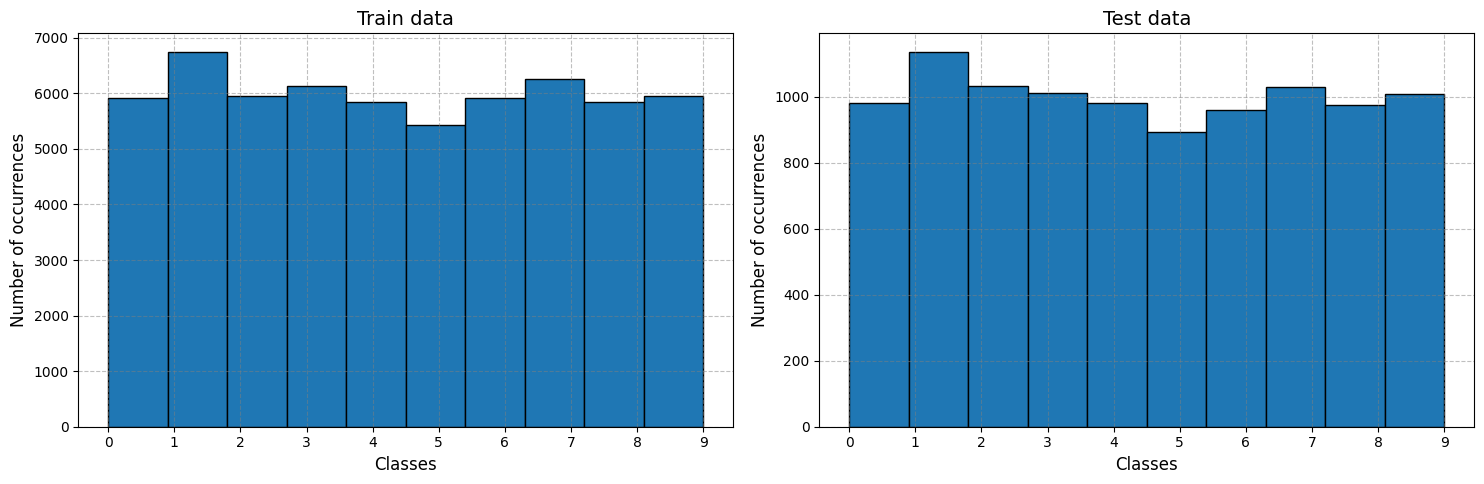

In [129]:

XTrain, YTrain = train_data.data, train_data.targets
XTest, YTest = test_data.data, test_data.targets



print('X_Train shape =', XTrain.shape)
print('X_Test shape =', XTest.shape)
# print('YTrain shape =', YTrain.shape)
# print('YTest shape =', YTest.shape)


print('YTrain values =', torch.unique(YTrain))
print('YTest values =', torch.unique(YTest))


train_class_counts = torch.bincount(YTrain)
test_class_counts = torch.bincount(YTest)
print('YTrain distribution =', {cls: count.item() for cls, count in enumerate(train_class_counts) if count.item() > 0})
print('YTest distribution =', {cls: count.item() for cls, count in enumerate(test_class_counts) if count.item() > 0})


fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(YTrain, ec='black')
axs[0].set_title('Train data')
axs[0].set_xlabel('Classes')
axs[0].set_ylabel('Number of occurrences')
axs[1].hist(YTest, ec='black')
axs[1].set_title('Test data')
axs[1].set_xlabel('Classes')
axs[1].set_ylabel('Number of occurrences')


axs[0].set_xticks(torch.unique(YTrain).numpy())
axs[1].set_xticks(torch.unique(YTest).numpy())

plt.show()


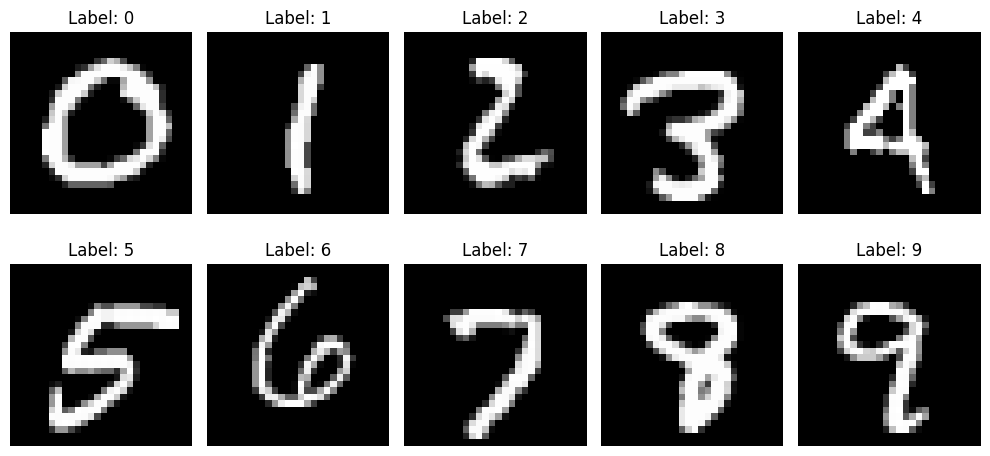

In [95]:
train_features, train_labels = next(iter(train_loader))


class_indices = {}
for idx, label in enumerate(train_labels):
    label = label.item()
    if label not in class_indices:
        class_indices[label] = idx
    if len(class_indices) == 10:
        break


images = [train_features[class_indices[i]] for i in range(10)]
labels = [train_labels[class_indices[i]] for i in range(10)]


fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = images[i].numpy().squeeze()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Principal Component Analysis (PCA)

PCA is a dimensionality reduction technique used to transform high-dimensional data into a lower-dimensional space while preserving essential information.

## Mathematics of PCA

1. **Data Standardization**: Standardize the data to have zero mean and unit variance:
   - $\bar{x}_j = \frac{1}{n} \sum_{i=1}^{n} x_{ij}$ (mean)
   - $x_{ij}^* = {x_{ij} - \bar{x}_j}$ (zero mean data)

2. **Covariance Matrix**: Compute the covariance matrix $C$:
   - $C = \frac{1}{n} X^T X$, where $C \in \mathbb{R}^{d \times d}$

3. **Eigenvector Decomposition**: Obtain eigenvectors $\mathbf{v}$ and eigenvalues $\lambda$ of $C$:
   - $C \mathbf{v} = \lambda \mathbf{v}$, where $\mathbf{v} \in \mathbb{R}^{d \times d}$ and $\lambda \in \mathbb{R}^d$

4. **Selecting Principal Components**: Choose the $k$ largest eigenvalues and their corresponding eigenvectors to form the matrix $\mathbf{V}_k \in \mathbb{R}^{d \times k}$.

5. **Projection onto Principal Components**: Project data onto principal components:
   - For a $k$-dimensional projection, transform $x_i$ as $x_i' = x_i^* \mathbf{V}_k$, where $x_i' \in \mathbb{R}^k$

## Image Transformation and Reconstruction

1. **Image Transformation**: Apply PCA to image pixel intensities:
   - Reshape images into vectors and perform PCA on these vectors.
   - Principal components represent dominant image features.

2. **Image Reconstruction**: Reconstruct images from PCA representation:
   - Given PCA-transformed vector $x_i'$ and eigenvectors $\mathbf{V}_k$, reconstruct image $\hat{x}_i$ as $\hat{x}_i = x_i' \mathbf{V}_k^T$, where $\hat{x}_i \in \mathbb{R}^d$

PCA efficiently captures essential data patterns, enabling compression and reconstruction while reducing dimensionality.


In [119]:
def pca(X, n_components):
   """
    Perform Principal Component Analysis (PCA) on the input data.

    Parameters:
    - X (torch.Tensor): Input data matrix with shape (n_samples, n_features).
    - n_components (int): Number of principal components to retain.

    Returns:
    - eigenvectors (torch.Tensor): Matrix of principal components with shape (n_features, n_components).
    - eigenvalues (torch.Tensor): Eigenvalues corresponding to the principal components.
    - X_mean (torch.Tensor): Mean of the input data.
    """

    X_mean = torch.mean(X, 0)
    X_centered = X - X_mean

    # Compute covariance matrix
    covariance_matrix = torch.matmul(X_centered.T, X_centered) / (X_centered.shape[0] - 1)

    # Eigen decomposition
    eigenvalues, eigenvectors = torch.linalg.eigh(covariance_matrix)
    eigenvalues = eigenvalues.real

    # Sort eigenvalues and eigenvectors
    sorted_indices = torch.argsort(eigenvalues, descending=True)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Select the top n_components
    eigenvectors = eigenvectors[:, :n_components]

    return eigenvectors, eigenvalues, X_mean

def find_components_for_variance(eigenvalues, variance_threshold):
    total_variance = torch.sum(eigenvalues)
    cumulative_variance = torch.cumsum(eigenvalues, 0) / total_variance
    n_components = torch.searchsorted(cumulative_variance, variance_threshold).item() + 1
    return n_components

def transform(X, eigenvectors, X_mean):
    X_centered = X - X_mean
    return torch.matmul(X_centered, eigenvectors)

def inverse_transform(X_projected, eigenvectors, X_mean):
    return torch.matmul(X_projected, eigenvectors.T) + X_mean

def compute_error(X, X_reconstructed):
    return torch.mean((X - X_reconstructed) ** 2)

def load_data():
    X_train = np.array([x.numpy().flatten() for x, _ in train_data])
    X_test = np.array([x.numpy().flatten() for x, _ in test_data])
    return X_train, X_test

In [151]:
X_train = torch.stack([x.flatten() for x, _ in train_data])
X_test = torch.stack([x.flatten() for x, _ in test_data])

##PCA with different PC

Performed PCA on the training data with 100 components, transformed and reconstructed both training and testing data, and computed reconstruction errors for evaluation.



In [135]:


# PCA on training data
Eigenvectors_100, eigenvalues_100,X_mean_100 = pca(X_train, n_components=100)  # Using 100 components for demonstration

# Transform training and testing data
X_train_projected_100 = transform(X_train, Eigenvectors_100, X_mean_100)
X_test_projected_100 = transform(X_test, Eigenvectors_100, X_mean_100)

# Reconstruct training and testing data
X_train_reconstructed_100 = inverse_transform(X_train_projected_100, Eigenvectors_100, X_mean_100)
X_test_reconstructed_100 = inverse_transform(X_test_projected_100, Eigenvectors_100, X_mean_100)

# Compute reconstruction error
train_error = compute_error(X_train, X_train_reconstructed_100)
test_error = compute_error(X_test, X_test_reconstructed_100)

print(f"Train Reconstruction Error: {train_error.item()}")
print(f"Test Reconstruction Error: {test_error.item()}")



Train Reconstruction Error: 0.0057413410395383835
Test Reconstruction Error: 0.005615864880383015


### Visualization of reconstruction

 Visualized the reconstruction quality by plotting original and reconstructed images from the testing data. Since the no. of components(100) is less than the total no. of componenst (728) some occlusions can be seen in the reconstructed image.


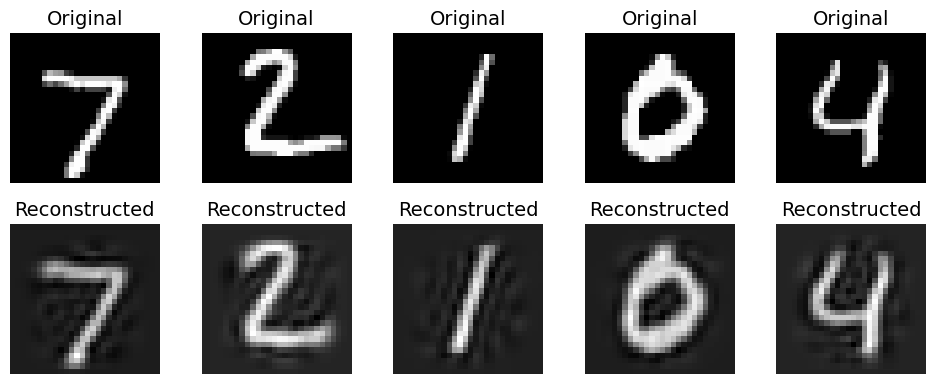

In [136]:
# Plotted original and reconstructed images to visualize the reconstruction quality
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    ax = axes[0, i]
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.set_title('Original')
    ax.axis('off')

    ax = axes[1, i]
    ax.imshow(X_test_reconstructed_100[i].reshape(28, 28), cmap='gray')
    ax.set_title('Reconstructed')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Effect of Variance threshold (PC component) onn reconstruction error


Conducted full PCA analysis for variances ranging from 0.2% to 99%, determining the number of components for each variance threshold and computing the reconstruction errors over the test dataset .


In [137]:

# From 20% to 99% variance explained
variance_thresholds = np.linspace(0.2, 0.99, 10)
errors = []

In [138]:


# Full PCA for analysis
eigenvectors, eigenvalues, X_mean = pca(X_train, X_train.shape[1])

# Analyze for each variance threshold
for variance_threshold in variance_thresholds:
    n_components = find_components_for_variance(eigenvalues, variance_threshold)
    eigenvectors_reduced, _, _ = pca(X_train, n_components)
    X_test_projected = transform(X_test, eigenvectors_reduced, X_mean)
    X_test_reconstructed = inverse_transform(X_test_projected, eigenvectors_reduced, X_mean)
    error = compute_error(X_test, X_test_reconstructed).item()
    errors.append(error)
    print(f"Variance Threshold: {variance_threshold*100:.1f}%, Components: {n_components}, Error: {error}")


Variance Threshold: 20.0%, Components: 3, Error: 0.05160897225141525
Variance Threshold: 28.8%, Components: 5, Error: 0.04452643543481827
Variance Threshold: 37.6%, Components: 7, Error: 0.03940919041633606
Variance Threshold: 46.3%, Components: 9, Error: 0.03559231013059616
Variance Threshold: 55.1%, Components: 14, Error: 0.02896874211728573
Variance Threshold: 63.9%, Components: 20, Error: 0.023538129404187202
Variance Threshold: 72.7%, Components: 30, Error: 0.01768656261265278
Variance Threshold: 81.4%, Components: 47, Error: 0.01214100606739521
Variance Threshold: 90.2%, Components: 89, Error: 0.006396734621375799
Variance Threshold: 99.0%, Components: 331, Error: 0.0006610146374441683


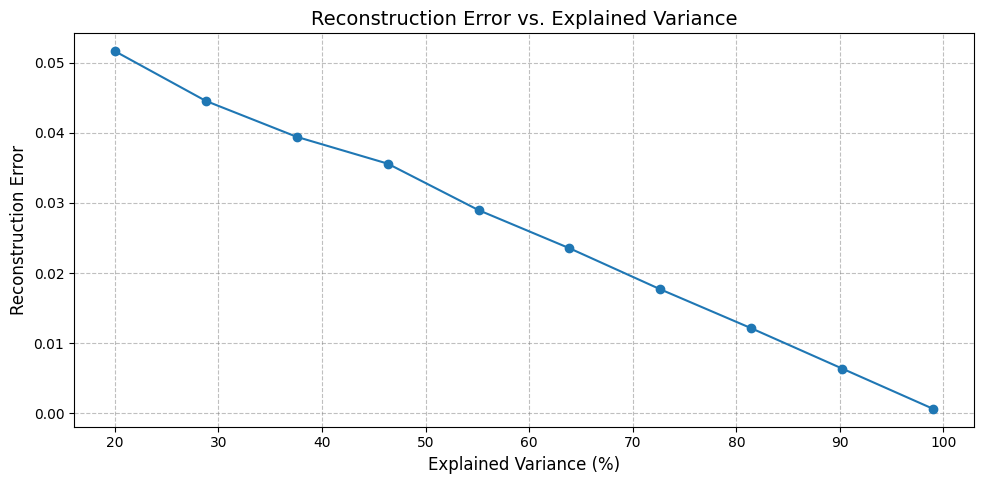

In [140]:
plt.figure(figsize=(10, 5))
plt.plot(variance_thresholds * 100, errors, marker='o')
plt.title('Reconstruction Error vs. Explained Variance')
plt.xlabel('Explained Variance (%)')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()



### Reconstruction at 90% variance

Displayed examples of original and reconstructed images from the testing data, where PCA was performed with a variance threshold of 90%.The reconstructed images are found to be close to the original images with slight blocking artifacts.



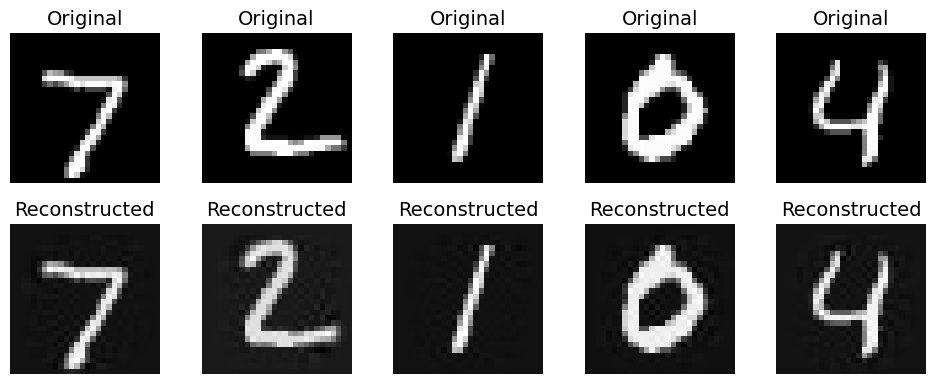

In [141]:
# Visualize examples of original vs. reconstructed images


fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    ax = axes[0, i]
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.set_title('Original')
    ax.axis('off')

    ax = axes[1, i]
    ax.imshow(X_test_reconstructed[i].reshape(28, 28), cmap='gray')
    ax.set_title('Reconstructed')
    ax.axis('off')

plt.tight_layout()
plt.show()

##PCA with scikit-learn

Utilized the PCA implementation from the scikit-learn library to apply PCA on the training data, transform the testing data, and reconstruct it based on a variance threshold of `variance_threshold`. Returned the number of components used, the reconstruction error, and the reconstructed testing data.

The rest of the analysis is pretty same to our pca code. This additional step is done to check if our pca code is working properly.

In [142]:

def apply_pca_and_reconstruct(X_train, X_test, variance_threshold):
    pca = PCA(n_components=variance_threshold)
    pca.fit(X_train)
    X_test_projected = pca.transform(X_test)
    X_test_reconstructed = pca.inverse_transform(X_test_projected)
    error = mean_squared_error(X_test, X_test_reconstructed)
    return pca.n_components_, error, X_test_reconstructed


In [149]:
X_train_pca, X_test_pca = load_data()
variance_thresholds = np.linspace(0.2, 0.99, 10)
components_list = []
errors = []



In [144]:
# Analyze for each variance threshold
for variance_threshold in variance_thresholds:
    n_components, error, _ = apply_pca_and_reconstruct(X_train_pca, X_test_pca, variance_threshold)
    components_list.append(n_components)
    errors.append(error)
    print(f"Variance Threshold: {variance_threshold:.2f}, Components: {n_components}, Reconstruction Error: {error}")




Variance Threshold: 0.20, Components: 3, Reconstruction Error: 0.05160892382264137
Variance Threshold: 0.29, Components: 5, Reconstruction Error: 0.04452640190720558
Variance Threshold: 0.38, Components: 7, Reconstruction Error: 0.03940916433930397
Variance Threshold: 0.46, Components: 9, Reconstruction Error: 0.03559228777885437
Variance Threshold: 0.55, Components: 14, Reconstruction Error: 0.02896871790289879
Variance Threshold: 0.64, Components: 20, Reconstruction Error: 0.023538118228316307
Variance Threshold: 0.73, Components: 30, Reconstruction Error: 0.017686547711491585
Variance Threshold: 0.81, Components: 47, Reconstruction Error: 0.01214099582284689
Variance Threshold: 0.90, Components: 89, Reconstruction Error: 0.0063967290334403515
Variance Threshold: 0.99, Components: 331, Reconstruction Error: 0.0006610132404603064


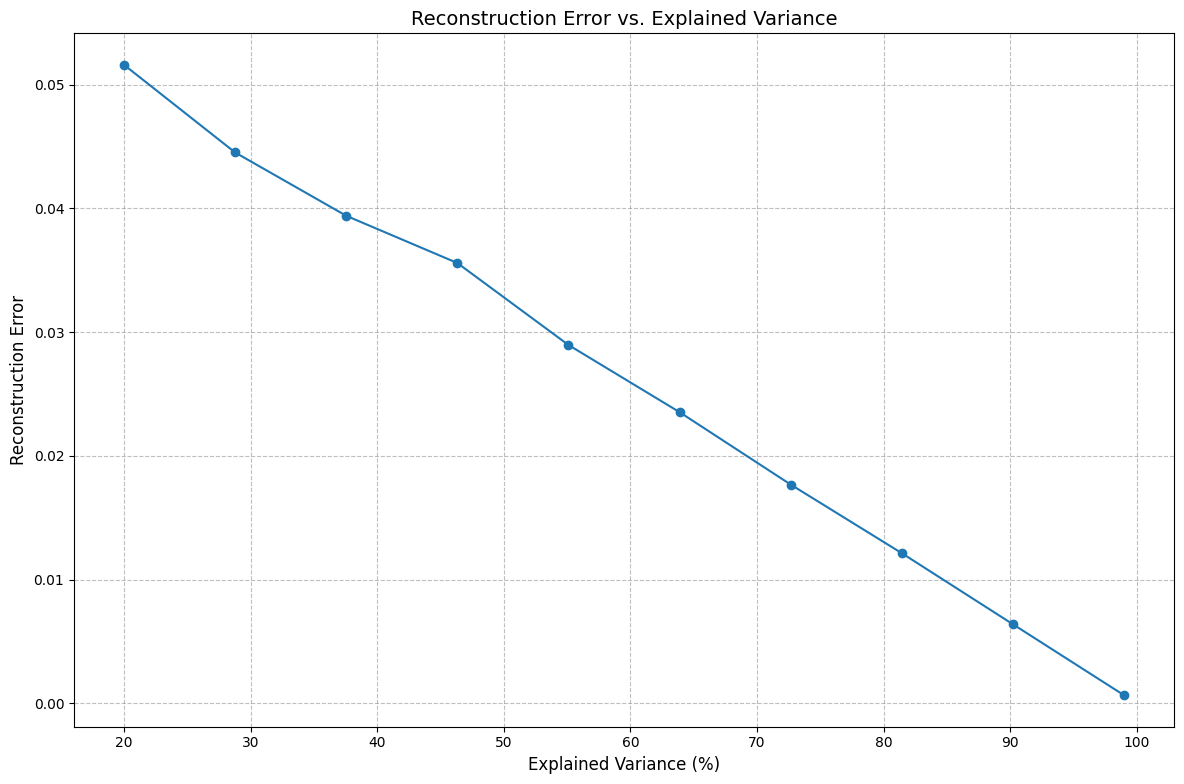

In [147]:
# plt.figure(figsize=(10, 5))
plt.plot(variance_thresholds * 100, errors, marker='o')
plt.title('Reconstruction Error vs. Explained Variance')
plt.xlabel('Explained Variance (%)')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()




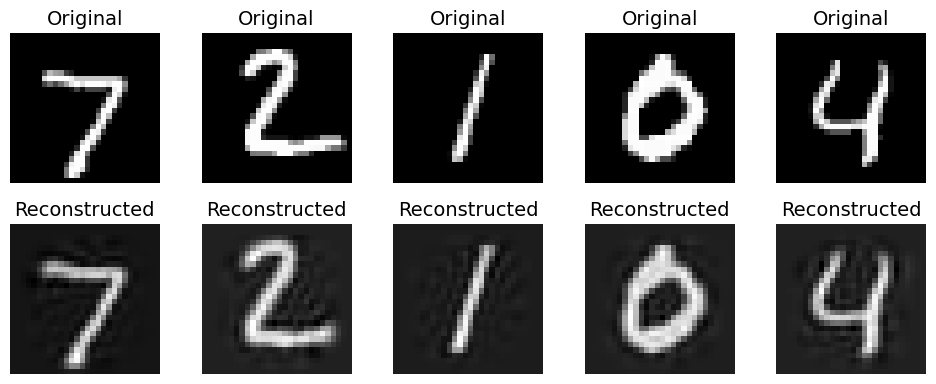

In [150]:
_, _, X_test_reconstructed_skpca = apply_pca_and_reconstruct(X_train_pca, X_test_pca, 0.9)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    ax = axes[0, i]
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.set_title('Original')
    ax.axis('off')

    ax = axes[1, i]
    ax.imshow(X_test_reconstructed_skpca[i].reshape(28, 28), cmap='gray')
    ax.set_title('Reconstructed')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Basis Functions

Principal Component Analysis (PCA) computes a set of orthogonal basis vectors, known as principal components, by finding the eigenvectors of the covariance matrix of the data.

### 1. Basis Function Calculation:

Given the MNIST dataset, PCA extracts basis functions that represent the dominant patterns or features in the images.

### 2. Visualization:

- The displayed images depict the first 10 principal components obtained from PCA analysis of the MNIST dataset.
- Brighter regions in the images indicate areas of higher importance or weight for the corresponding component.
- These components provide a coarse representation of the digits, capturing global structures and patterns.

### 3. Interpretation:

- In the context of MNIST digits, the basis functions are represent fundamental features such as strokes, curves, or loops of numbers liek 0, 9, 6 , 8 etc.
- The first few components typically capture broader strokes and shapes, while subsequent components capture finer details or variations within the digits.

PCA offers an efficient means of dimensionality reduction and feature extraction, enabling concise representation and analysis of complex datasets.

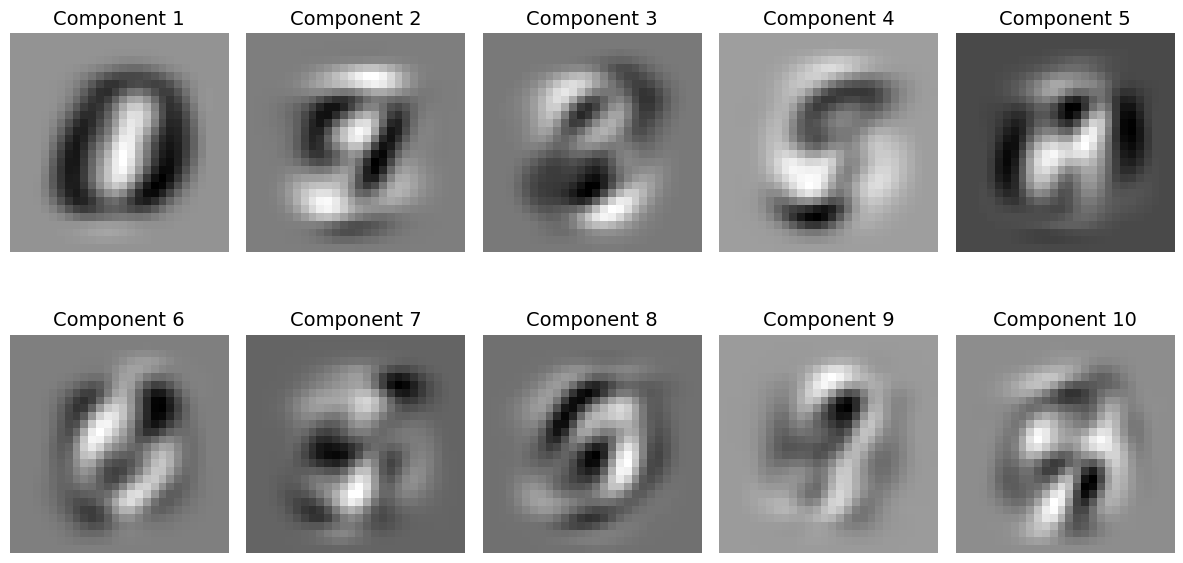

In [152]:

num_components = 10
eigenvectors,eigenvalues, mean_image = pca(X_train, num_components)

# Visualize the first 10 principal components
fig, axes = plt.subplots(2, 5)
for i, ax in enumerate(axes.flat):
    component = eigenvectors[:, i].reshape(28, 28)
    ax.imshow(component, cmap='gray')
    ax.set_title(f'Component {i + 1}')
    ax.axis('off')
plt.tight_layout()
plt.show()



### Image reconstruction trend with increasing number of components

Reconstructed an MNIST image using increasing numbers of components from PCA, showcasing how the quality of the reconstruction improves as more components are utilized. As the number of components increases, capturing more variance in the data, the reconstruction error decreases, resulting in finer details and higher fidelity in the reconstructed images. This visualization demonstrates the trade-off between computational efficiency and reconstruction accuracy in PCA-based dimensionality reduction.


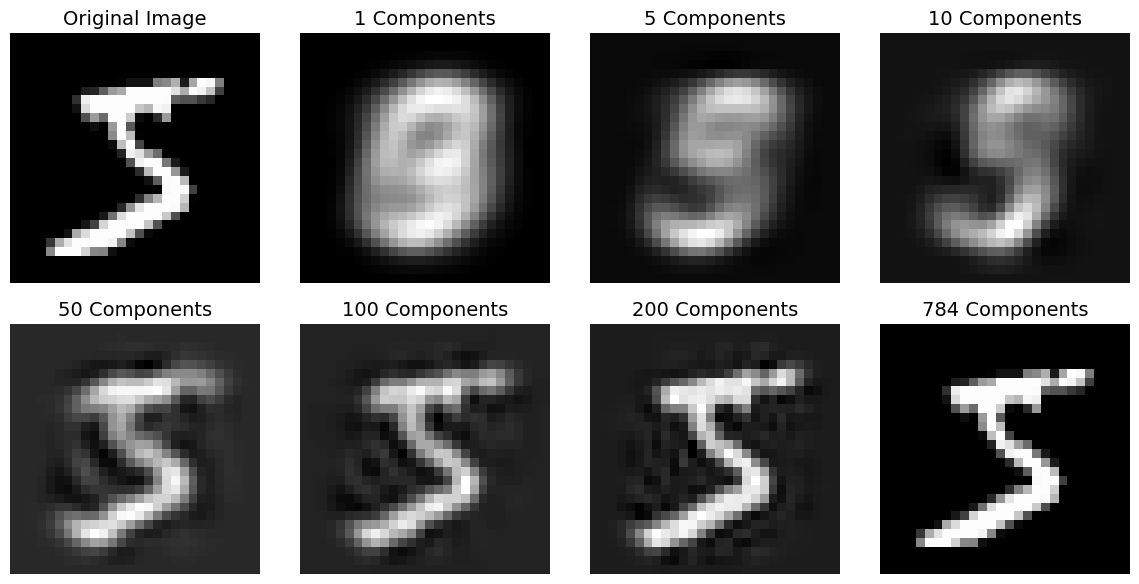

In [153]:

image_index = 0
original_image = X_train[image_index].reshape(28, 28)
components_used = [1, 5, 10, 50, 100, 200, 784]
reconstructions = []

# Reconstruct the image using increasing number of components
for comps in components_used:
    eigenvectors,eigenvalues, mean_image = pca(X_train, comps)
    X_projected = transform(X_train[image_index:image_index+1], eigenvectors, mean_image)
    X_reconstructed = inverse_transform(X_projected, eigenvectors, mean_image)
    reconstructions.append(X_reconstructed.reshape(28, 28))

# Plot the original and the reconstructions
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes[0, 0].imshow(original_image, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

for i, ax in enumerate(axes.flat[1:]):
    if i < len(reconstructions):
        ax.imshow(reconstructions[i], cmap='gray')
        ax.set_title(f'{components_used[i]} Components')
        ax.axis('off')
plt.tight_layout()
plt.show()

## Classification Capacity

Here we have visualized the MNIST dataset transformed into a 3D PCA space, aiming to explore the variability of digit classes. While some digits exhibit distinct clusters, the majority appear scattered, suggesting that PCA alone may not provide sufficient discriminatory power for classification tasks.


In [163]:

class_counts = {i: 0 for i in range(10)}
X_train_list = []
labels_list = []

for x, y in train_data:
    if class_counts[y] < 50:
        X_train_list.append(x.flatten())
        labels_list.append(y)
        class_counts[y] += 1
    if all(count == 50 for count in class_counts.values()):
        break

X_train_small = torch.stack(X_train_list).float()
labels_small = torch.tensor(labels_list, dtype=torch.long)

In [164]:
X_train_small.shape,labels_small.shape

(torch.Size([500, 784]), torch.Size([500]))

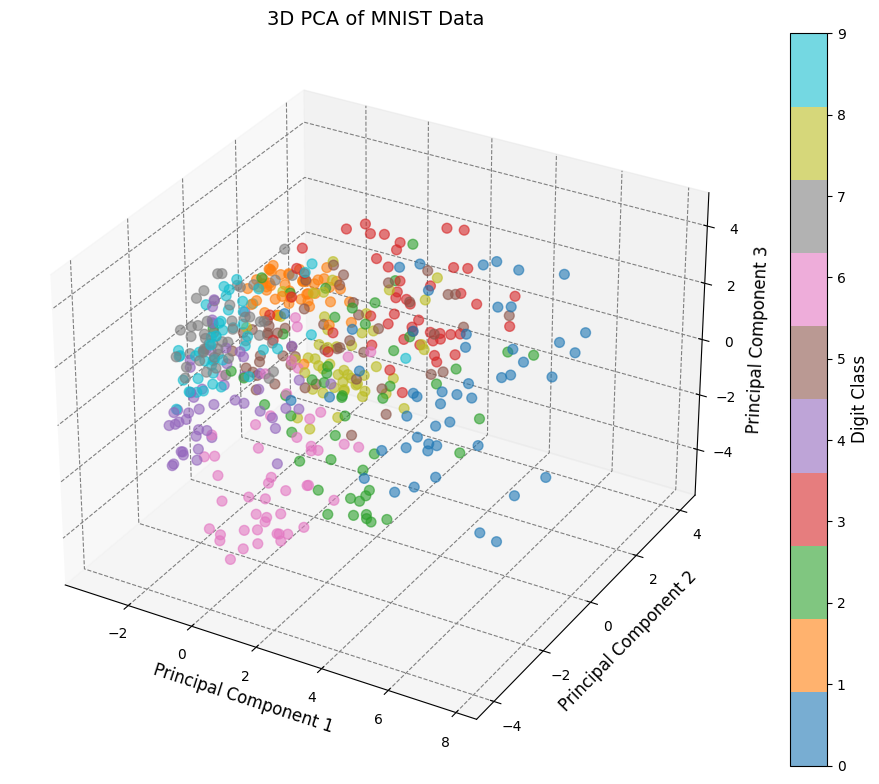

In [165]:

eigenvectors, eigenvalues, X_mean = pca(X_train_small, 3)
X_projected = transform(X_train_small, eigenvectors, X_mean)

# Prepare 3D plot
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

# Plot each point in 3D PCA space
sc = ax.scatter(X_projected[:, 0], X_projected[:, 1], X_projected[:, 2], c=labels_small, cmap='tab10', s=50, alpha=0.6)
cbar = plt.colorbar(sc, ticks=range(10))
cbar.set_label('Digit Class')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of MNIST Data')

plt.show()

In [168]:
train_loader_enc = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader_enc = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)


# Autoencoders for Data Reduction

Autoencoders are neural network models designed for unsupervised learning, where the network learns to encode the input data into a lower-dimensional representation and then decode it back to the original space. This process is achieved through an encoder-decoder architecture, where the encoder compresses the input data into a latent representation, and the decoder reconstructs the original data from this representation.

## Mathematics of Autoencoders

1. **Encoder**: The encoder function, denoted as $f_{\text{enc}}$, maps the input data $X$ to a latent representation $Z$:  
   $$ Z = f_{\text{enc}}(X) $$

2. **Decoder**: The decoder function, denoted as $f_{\text{dec}}$, reconstructs the original data $\hat{X}$ from the latent representation $Z$:  
   $$ \hat{X} = f_{\text{dec}}(Z) $$

3. **Loss Function**: Autoencoders are trained to minimize a reconstruction loss, typically the mean squared error (MSE), between the input data $X$ and its reconstruction $\hat{X}$:
   $$ \text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (X_i - \hat{X}_i)^2 $$

## Data Reduction with Autoencoders

Autoencoders can be used for data reduction by training the model with a bottleneck layer, forcing the network to learn a compact representation of the input data. By encoding the data into a lower-dimensional space, autoencoders effectively reduce the dimensionality of the data while preserving its essential features. The latent representation obtained from the bottleneck layer serves as a compressed representation of the original data, enabling efficient storage, transmission, and analysis of high-dimensional datasets.


In [192]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model Architechture

The Autoencoder we have used is an encoder-decoder architecture where the encoder consists of three fully connected layers with input dimensions of 28x28 and output dimensions of 10, compressed into a bottleneck layer. The decoder comprises three fully connected layers with input dimensions of 10 and output dimensions of 28x28, using ReLU activation functions for encoding and decoding, and a sigmoid activation function for outputting values between 0 and 1.


In [167]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),

        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Using sigmoid to output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [116]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5)


num_epochs = 100
best_loss = float('inf')


# Counter for consecutive epochs with no improvement
no_improvement_count = 0

In [191]:
from torchsummary import summary
model = Autoencoder()
summary(model, (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 10]             650
            Linear-6                   [-1, 64]             704
              ReLU-7                   [-1, 64]               0
            Linear-8                  [-1, 128]           8,320
              ReLU-9                  [-1, 128]               0
           Linear-10                  [-1, 784]         101,136
          Sigmoid-11                  [-1, 784]               0
Total params: 219,546
Trainable params: 219,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

## Model Training

In [117]:

training_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)

        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)  # Calculate average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    training_losses.append(epoch_loss)  # Store the training loss for this epoch

    # Check if current epoch's loss is better than the best loss
    if epoch_loss < best_loss:
        # print("New best model found. Saving the model...")
        torch.save(model.state_dict(), 'best_model.pt')  # Save the model
        best_loss = epoch_loss  # Update best loss
        no_improvement_count = 0  # Reset no improvement counter
    else:
        no_improvement_count += 1  # Increment no improvement counter

        # Check if there has been no improvement for 5 consecutive epochs
        if no_improvement_count >= 5:
            print("No improvement in training loss for 5 epochs. Reducing learning rate and breaking the loop.")
            scheduler.step(epoch_loss)  # Adjust learning rate
            break

    # Step the learning rate scheduler
    scheduler.step(epoch_loss)




Epoch [1/100], Loss: 0.2311
Epoch [2/100], Loss: 0.2198
Epoch [3/100], Loss: 0.1945
Epoch [4/100], Loss: 0.1395
Epoch [5/100], Loss: 0.0912
Epoch [6/100], Loss: 0.0904
Epoch [7/100], Loss: 0.0902
Epoch [8/100], Loss: 0.0878
Epoch [9/100], Loss: 0.0910
Epoch [10/100], Loss: 0.0869
Epoch [11/100], Loss: 0.0842
Epoch [12/100], Loss: 0.0835
Epoch [13/100], Loss: 0.0816
Epoch [14/100], Loss: 0.0795
Epoch [15/100], Loss: 0.0784
Epoch [16/100], Loss: 0.0769
Epoch [17/100], Loss: 0.0753
Epoch [18/100], Loss: 0.0742
Epoch [19/100], Loss: 0.0734
Epoch [20/100], Loss: 0.0727
Epoch [21/100], Loss: 0.0721
Epoch [22/100], Loss: 0.0715
Epoch [23/100], Loss: 0.0708
Epoch [24/100], Loss: 0.0702
Epoch [25/100], Loss: 0.0698
Epoch [26/100], Loss: 0.0696
Epoch [27/100], Loss: 0.0694
Epoch [28/100], Loss: 0.0691
Epoch [29/100], Loss: 0.0688
Epoch [30/100], Loss: 0.0685
Epoch [31/100], Loss: 0.0683
Epoch [32/100], Loss: 0.0682
Epoch [33/100], Loss: 0.0681
Epoch [34/100], Loss: 0.0678
Epoch [35/100], Loss: 0

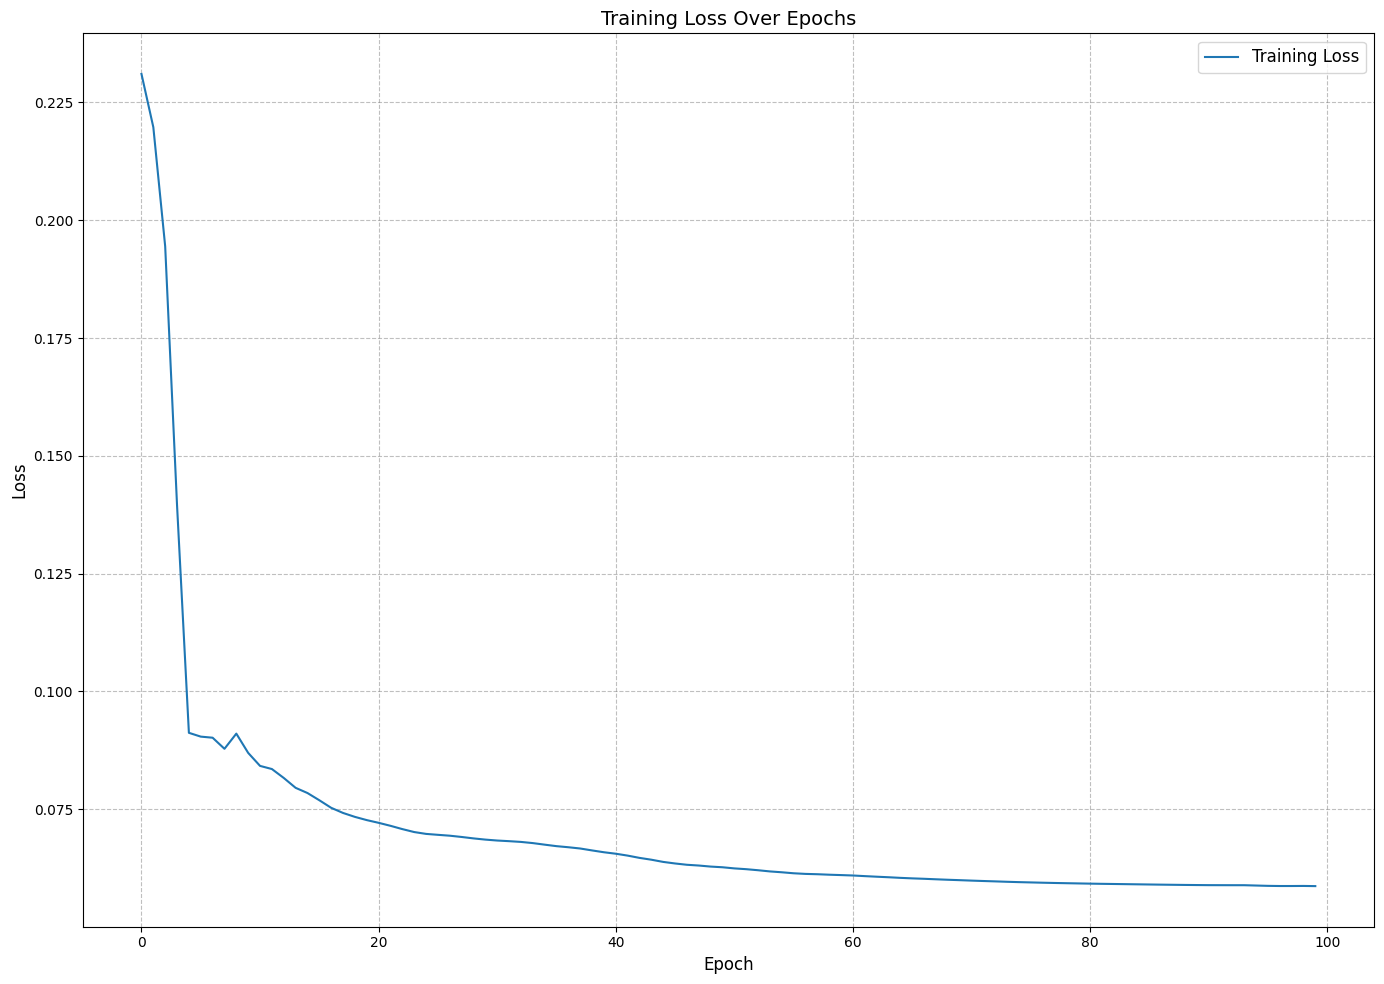

In [121]:

plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [171]:
batched_model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(batched_model.parameters(), lr=0.008)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5)


num_epochs = 100
best_loss = float('inf')


# Counter for consecutive epochs with no improvement
no_improvement_count = 0

In [172]:
training_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader_enc:
        img, _ = data
        img = img.view(img.size(0), -1)

        optimizer.zero_grad()
        output = batched_model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader_enc.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    training_losses.append(epoch_loss)


    if epoch_loss < best_loss:
        torch.save(batched_model.state_dict(), 'best_batch_model.pt')  # Save the model
        best_loss = epoch_loss  # Update best loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= 5:
            print("No improvement in training loss for 5 epochs. Reducing learning rate and breaking the loop.")
            scheduler.step(epoch_loss)  # Adjust learning rate
            break

    # Step the learning rate scheduler
    scheduler.step(epoch_loss)

Epoch [1/100], Loss: 0.0369
Epoch [2/100], Loss: 0.0227
Epoch [3/100], Loss: 0.0202
Epoch [4/100], Loss: 0.0194
Epoch [5/100], Loss: 0.0189
Epoch [6/100], Loss: 0.0185
Epoch [7/100], Loss: 0.0183
Epoch [8/100], Loss: 0.0181
Epoch [9/100], Loss: 0.0180
Epoch [10/100], Loss: 0.0178
Epoch [11/100], Loss: 0.0177
Epoch [12/100], Loss: 0.0176
Epoch [13/100], Loss: 0.0175
Epoch [14/100], Loss: 0.0176
Epoch [15/100], Loss: 0.0175
Epoch [16/100], Loss: 0.0174
Epoch [17/100], Loss: 0.0174
Epoch [18/100], Loss: 0.0173
Epoch [19/100], Loss: 0.0173
Epoch [20/100], Loss: 0.0172
Epoch [21/100], Loss: 0.0172
Epoch [22/100], Loss: 0.0172
Epoch [23/100], Loss: 0.0171
Epoch [24/100], Loss: 0.0171
Epoch [25/100], Loss: 0.0171
Epoch [26/100], Loss: 0.0171
Epoch [27/100], Loss: 0.0170
Epoch [28/100], Loss: 0.0170
Epoch [29/100], Loss: 0.0170
Epoch [30/100], Loss: 0.0169
Epoch [31/100], Loss: 0.0169
Epoch [32/100], Loss: 0.0169
Epoch [33/100], Loss: 0.0169
Epoch [34/100], Loss: 0.0168
Epoch [35/100], Loss: 0

In [173]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Evaluate the model on the test dataset
test_loss = 0.0
predictions = []
with torch.no_grad():
    for data, _ in test_loader:
        data = data.view(-1, 28*28).to(device)
        reconstructions = model(data)
        loss = criterion(reconstructions, data)
        test_loss += loss.item() * data.size(0)
        predictions.append(reconstructions.cpu().numpy())

test_loss /= len(test_loader.dataset)
print(f"Test MSE Loss: {test_loss:.4f}")

# Calculate RMSE
rmse = np.sqrt(test_loss)
print(f"Test RMSE: {rmse:.4f}")
predictions = np.concatenate(predictions, axis=0)

# Calculate MAE
mae = np.mean(np.abs(predictions - data.cpu().numpy()))
print(f"Test MAE: {mae:.4f}")


Test MSE Loss: 0.0354
Test RMSE: 0.1883
Test MAE: 0.0836


## Auto encoder representation

Plotted original and reconstructed images for each class using the Autoencoder model. While the output shapes may not precisely match the input number shapes, they still represent the essential semantics; for instance, number 9 is represented by number 9, albeit with slightly different curves and loops. This suggests that the Autoencoder has learned the fundamental representation of each number, which can facilitate generation and reconstruction tasks.


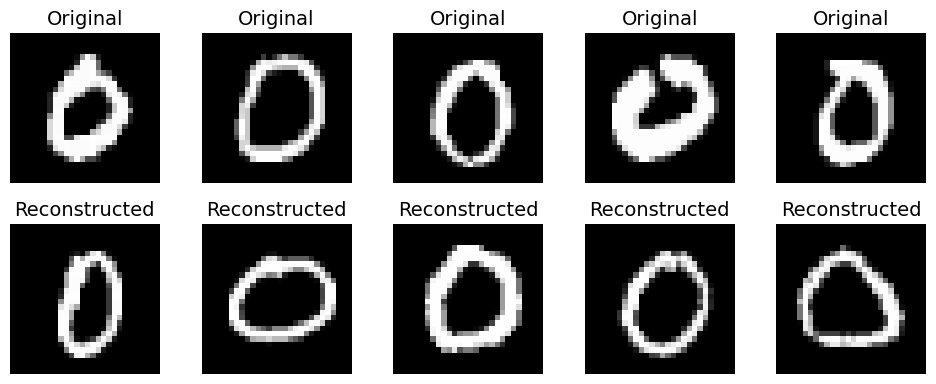

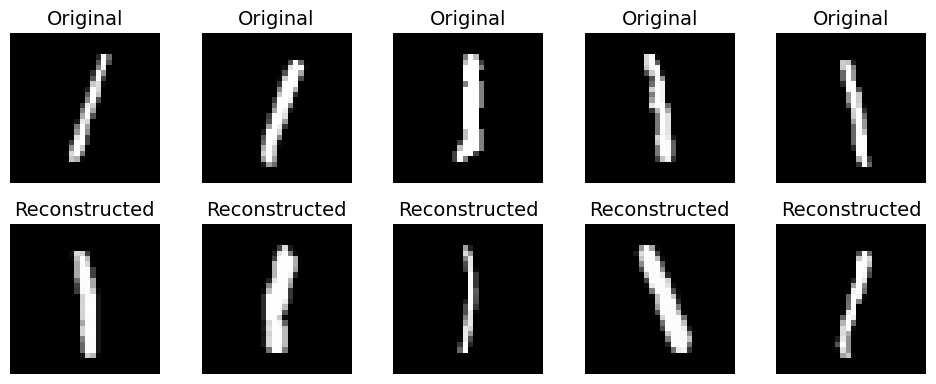

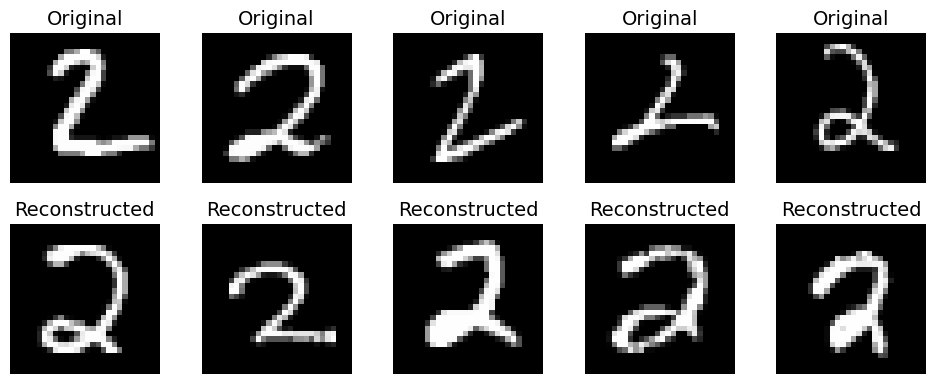

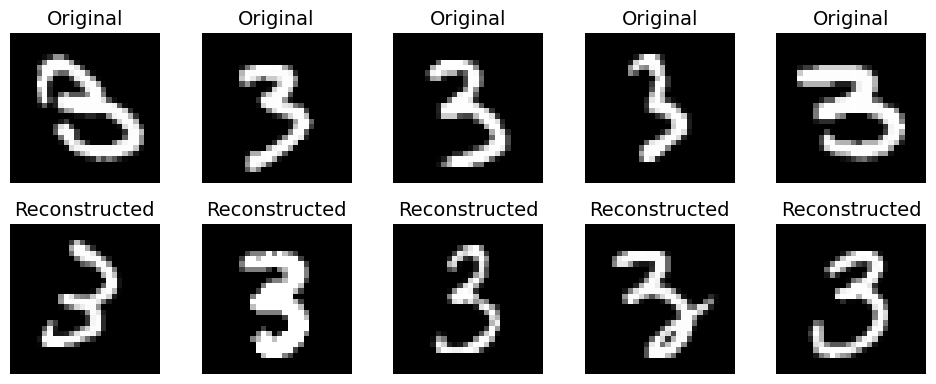

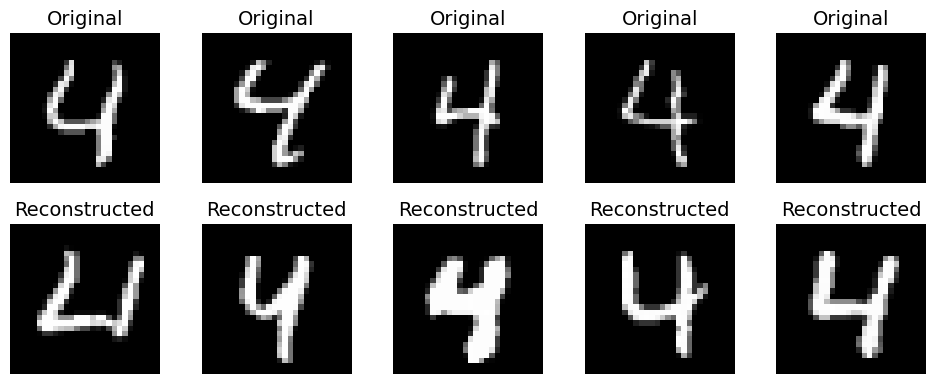

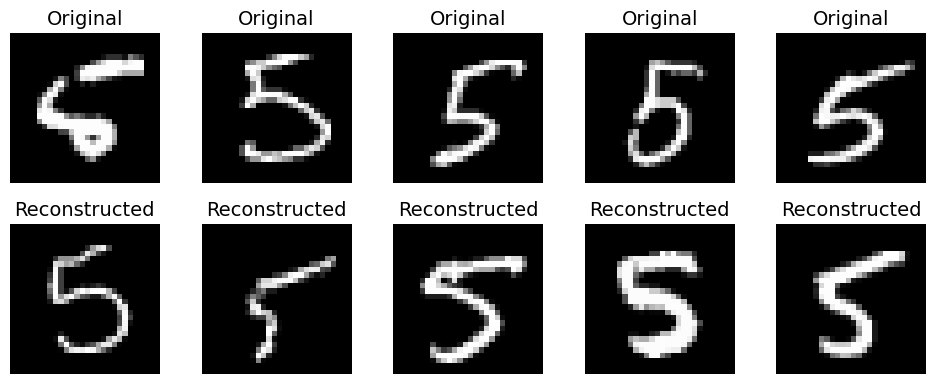

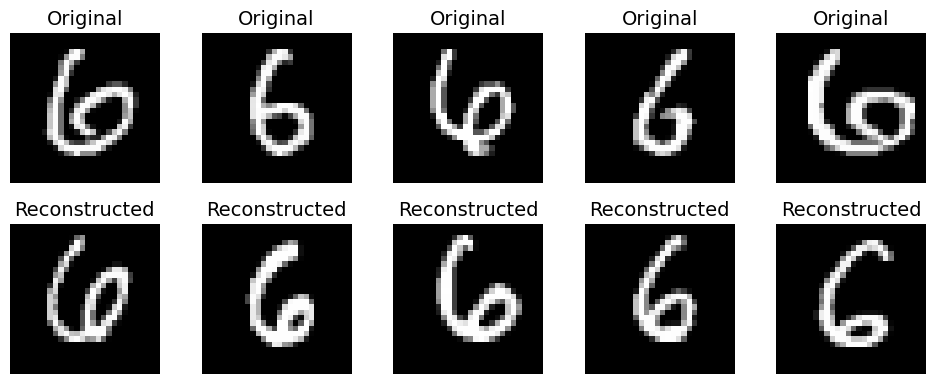

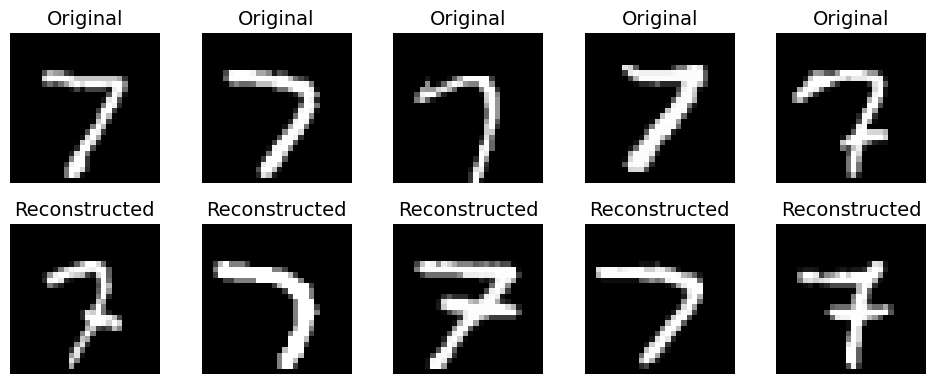

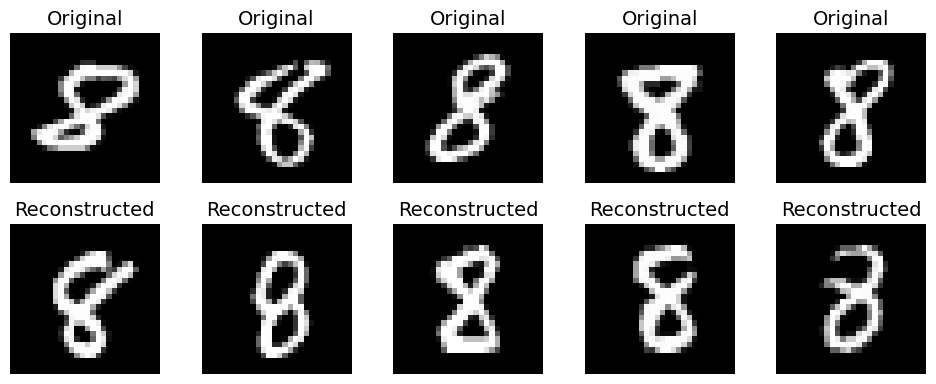

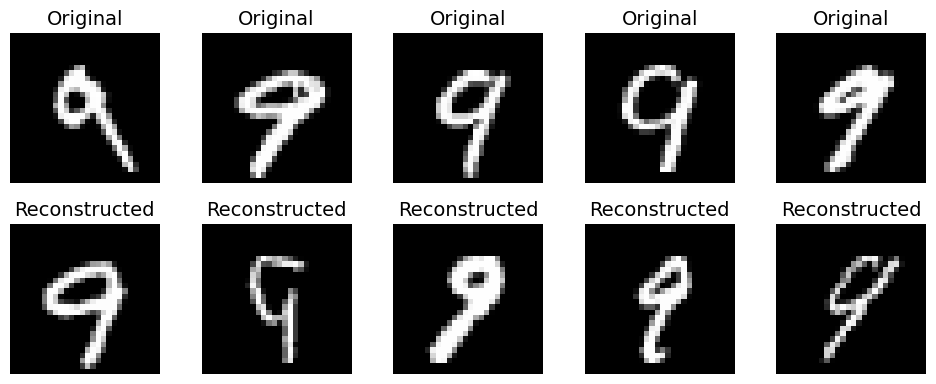

In [174]:
# Plot original and reconstructed images for each class
def plot_images_for_class(data_loader, model, class_label):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    images = []
    for data, labels in data_loader:
        for i in range(len(labels)):
            if labels[i] == class_label:
                images.append(data[i])

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].numpy().squeeze(), cmap='gray')
        ax.axis('off')
        if i < 5:
            ax.set_title('Original')
        else:
            ax.set_title('Reconstructed')

    plt.tight_layout()
    plt.show()

for i in range(10):
    plot_images_for_class(test_loader, model, i)

In [176]:
batched_model.load_state_dict(torch.load('best_batch_model.pt'))
batched_model.eval()

# Evaluate the model on the test dataset
test_loss = 0.0
predictions = []
with torch.no_grad():
    for data, _ in test_loader_enc:
        data = data.view(-1, 28*28).to(device)
        reconstructions = batched_model(data)
        loss = criterion(reconstructions, data)
        test_loss += loss.item() * data.size(0)
        predictions.append(reconstructions.cpu().numpy())

test_loss /= len(test_loader_enc.dataset)
print(f"Test MSE Loss: {test_loss:.4f}")

# Calculate RMSE
rmse = np.sqrt(test_loss)
print(f"Test RMSE: {rmse:.4f}")
predictions = np.concatenate(predictions, axis=0)

# # Calculate MAE
# mae = np.mean(np.abs(predictions - data.cpu().numpy()))
# print(f"Test MAE: {mae:.4f}")


Test MSE Loss: 0.0169
Test RMSE: 0.1302


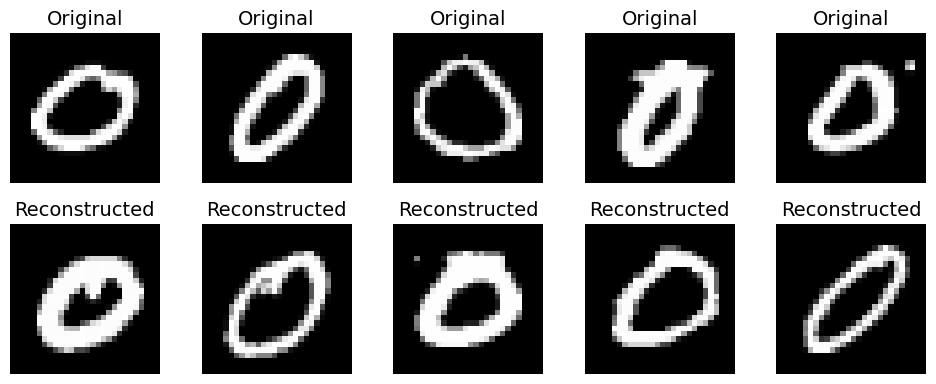

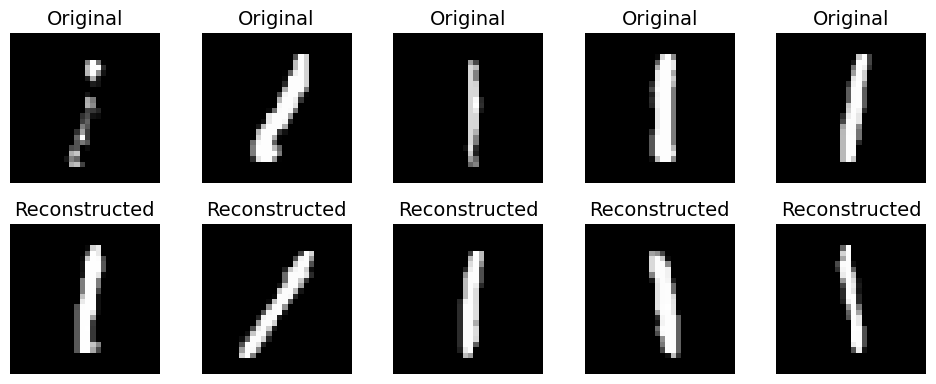

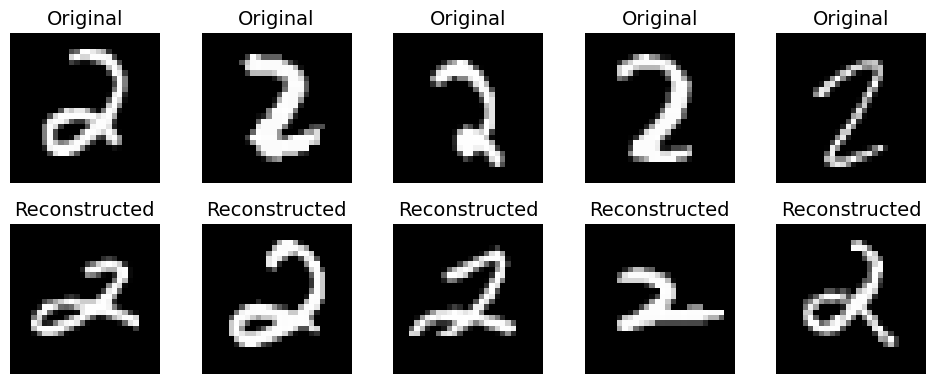

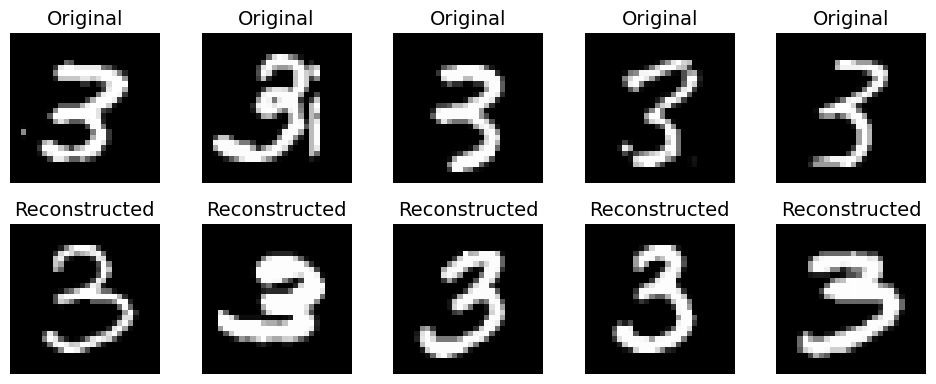

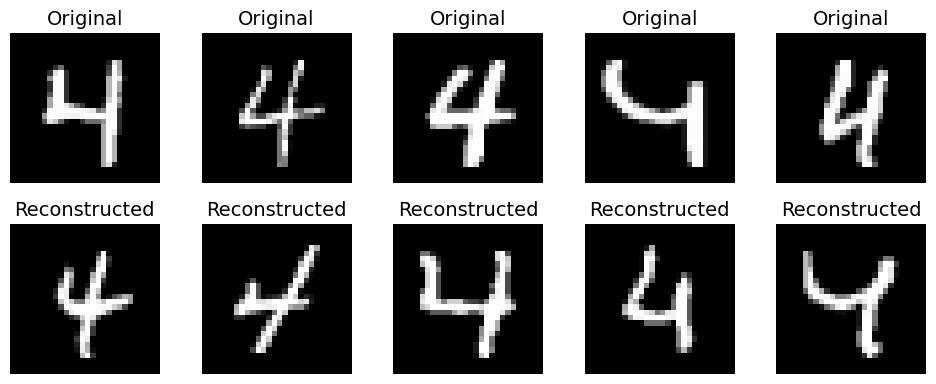

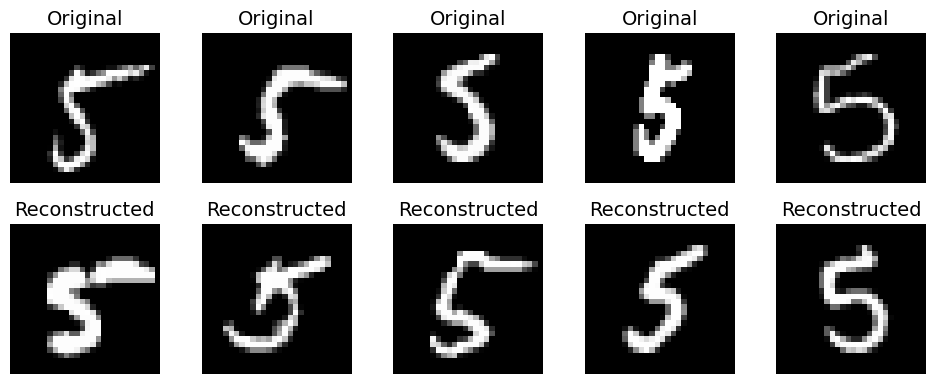

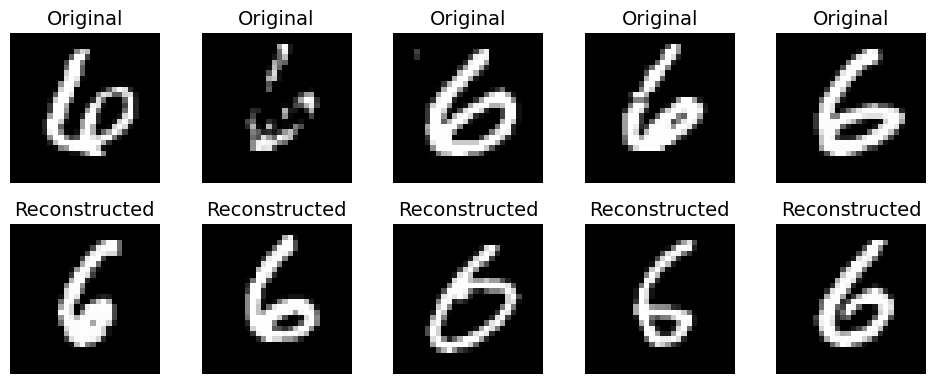

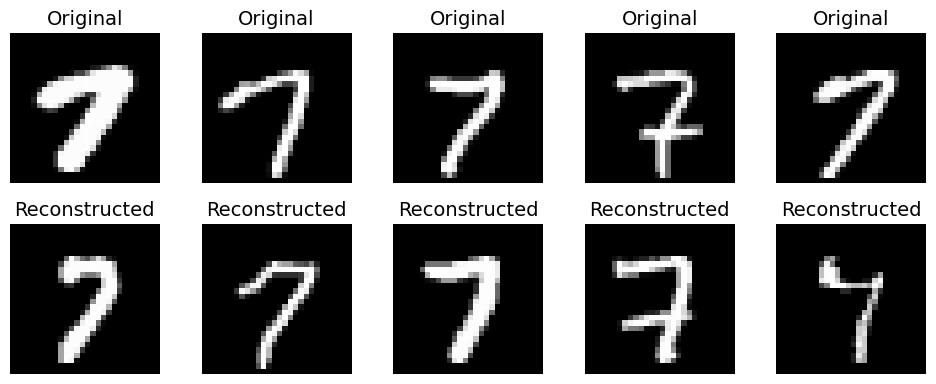

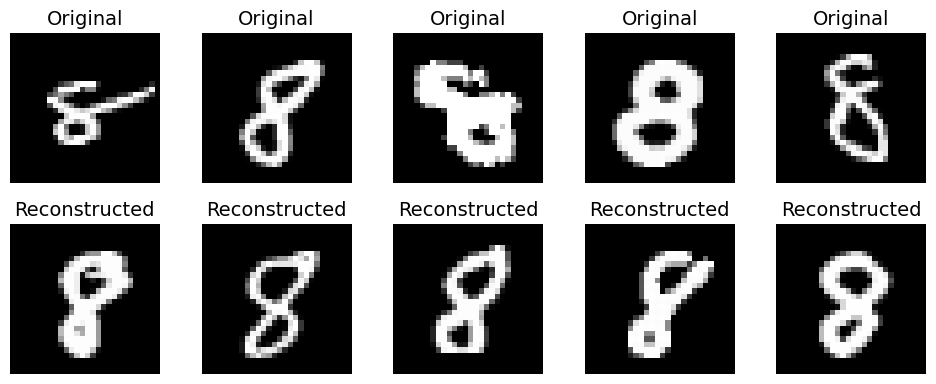

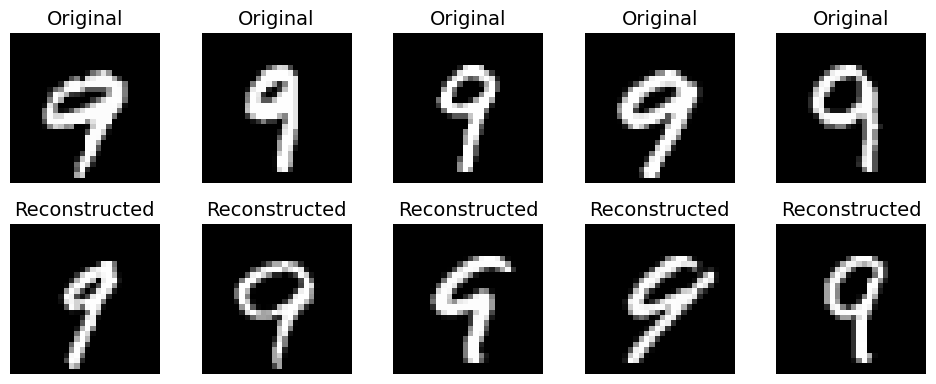

In [177]:

def plot_images_for_class(data_loader, model, class_label):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    images = []
    for data, labels in data_loader:
        for i in range(len(labels)):
            if labels[i] == class_label:
                images.append(data[i])

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].numpy().squeeze(), cmap='gray')
        ax.axis('off')
        if i < 5:
            ax.set_title('Original')
        else:
            ax.set_title('Reconstructed')

    plt.tight_layout()
    plt.show()

for i in range(10):
    plot_images_for_class(test_loader_enc, batched_model, i)

## Stabilty of dimension reduction using noise supression

Created a noisy dataset for testing the Autoencoder and PCA results by adding Gaussian noise to the images in the MNIST dataset.


In [179]:
def add_noise(img, noise_level=0.1):
    noise = torch.randn(img.size()) * noise_level
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.)


class NoisyMNIST(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]
        noisy_img = add_noise(img)
        return noisy_img, label

noisy_test_data = NoisyMNIST(test_data)
noisy_test_loader = torch.utils.data.DataLoader(noisy_test_data, batch_size=64, shuffle=False)

In [190]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()

test_loss = 0.0
predictions = []
with torch.no_grad():
    for data, _ in noisy_test_loader:
        data = data.view(-1, 28*28).to(device)
        reconstructions = model(data)
        loss = criterion(reconstructions, data)
        test_loss += loss.item() * data.size(0)
        predictions.append(reconstructions.cpu().numpy())

test_loss /= len(noisy_test_loader.dataset)
print(f"Autoencoder Test MSE Loss: {test_loss:.4f}")




Autoencoder Test MSE Loss: 0.0383


In [182]:

X_noisy_test = torch.stack([x[0].flatten() for x in noisy_test_data])
X_noisy_test_projected = transform(X_noisy_test, eigenvectors_reduced, X_mean)
X_noisy_test_reconstructed = inverse_transform(X_noisy_test_projected, eigenvectors_reduced, X_mean)
pca_error = compute_error(X_noisy_test, X_noisy_test_reconstructed).item()
print(f"PCA Reconstruction Error on Noisy Test Data: {pca_error:.4f}")


PCA Reconstruction Error on Noisy Test Data: 0.0032


## Noise Supression in Auto encoder

Visualized the reconstructions of noisy images using both Autoencoder and PCA. The Autoencoder effectively removes noise, resulting in cleaner reconstructions, albeit with some loss of detail due to oversmoothing. In contrast, PCA reconstructs the images with noise still present, demonstrating the Autoencoder's capacity for noise suppression.


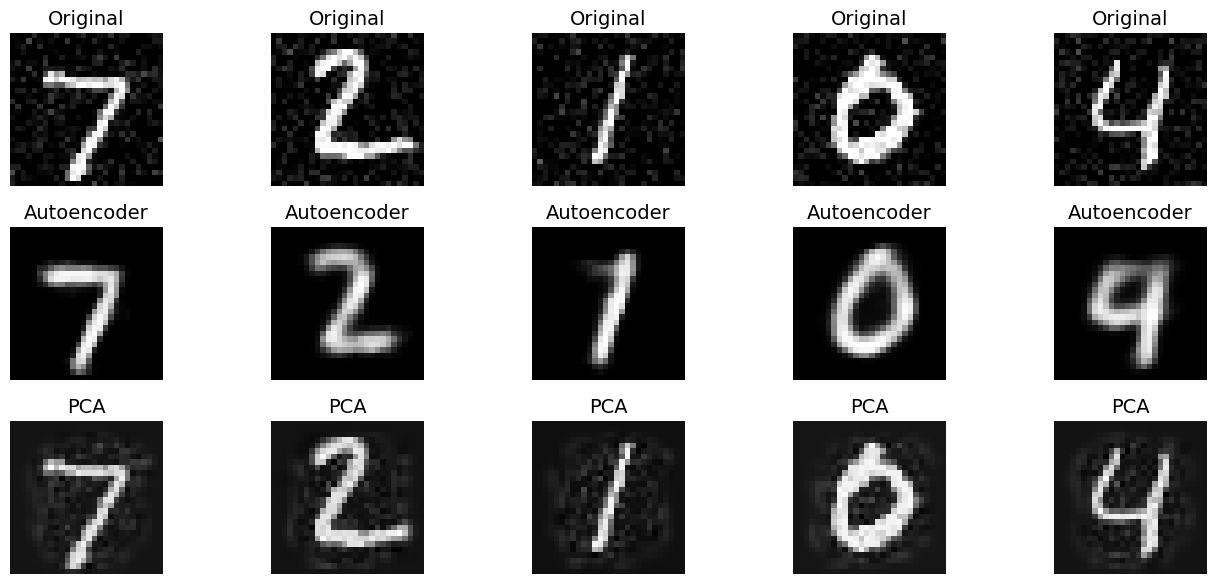

In [189]:

model.load_state_dict(torch.load('best_model.pt'))
model.eval()



noisy_data, _ = next(iter(noisy_test_loader))
noisy_data_flat = noisy_data.view(-1, 28*28).to(device)

# Generate reconstructions using Autoencoder
with torch.no_grad():
    autoencoder_reconstructions = model(noisy_data_flat).view(-1, 28, 28).cpu()

# Generate reconstructions using PCA
X_noisy_test = noisy_data.view(-1, 28*28)
X_noisy_test_projected = transform(X_noisy_test, eigenvectors_reduced, X_mean)
X_noisy_test_reconstructed = inverse_transform(X_noisy_test_projected, eigenvectors_reduced, X_mean)


fig, axes = plt.subplots(3, 5, figsize=(15, 6), sharex=True, sharey=True)

for i in range(5):
    # Original images
    axes[0, i].imshow(noisy_data[i].squeeze(), cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    # Autoencoder reconstructed images
    axes[1, i].imshow(autoencoder_reconstructions[i].squeeze(), cmap='gray')
    axes[1, i].set_title('Autoencoder')
    axes[1, i].axis('off')

    # PCA reconstructed images
    axes[2, i].imshow(X_noisy_test_reconstructed[i].reshape(28, 28), cmap='gray')
    axes[2, i].set_title('PCA')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


<ipython-input-195-aaaa4ebd82de>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  encoded_representations = torch.tensor(encoded_representations)


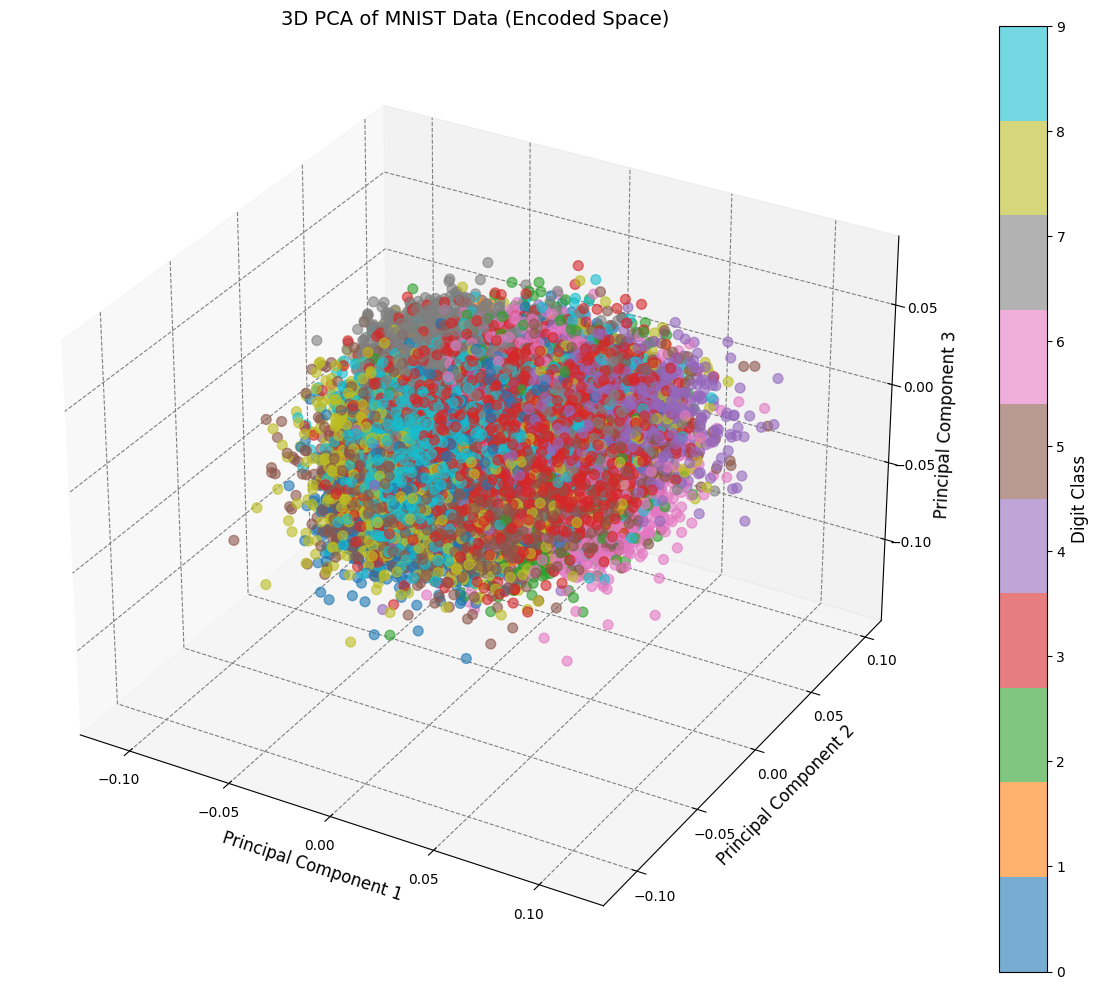

In [195]:

# model.eval()

# # Lists to store the encoded representations and labels
# encoded_representations = []
# labels_list = []

# # Encode each data point and collect the encoded representations and labels
# with torch.no_grad():
#     for x, y in train_data:
#         encoded = model.encoder(x.flatten()).detach().numpy()
#         encoded_representations.append(encoded)
#         labels_list.append(y)

# # Convert lists to tensors
# encoded_representations = torch.tensor(encoded_representations)
# labels_small = torch.tensor(labels_list, dtype=torch.long)

# # Perform PCA on the encoded representations
# eigenvectors, eigenvalues, X_mean = pca(encoded_representations, 3)
# X_projected = transform(encoded_representations, eigenvectors, X_mean)


# fig = plt.figure(figsize=(12, 10))
# ax = fig.add_subplot(111, projection='3d')


# sc = ax.scatter(X_projected[:, 0], X_projected[:, 1], X_projected[:, 2], c=labels_small, cmap='tab10', s=50, alpha=0.6)
# cbar = plt.colorbar(sc, ticks=range(10))
# cbar.set_label('Digit Class')
# ax.set_xlabel('Principal Component 1')
# ax.set_ylabel('Principal Component 2')
# ax.set_zlabel('Principal Component 3')
# ax.set_title('3D PCA of MNIST Data (Encoded Space)')

# plt.show()


# Summary


## Comparing PCA and Autoencoder on MNIST

### Differences:
1. **Basis Representation**:
   - PCA learns the statistically most important basis vectors that capture the maximum variance in the data, offering a global perspective.
   - Autoencoder, however, learns the fundamental representations within each class, capturing intricate details such as curves, loops, and other distinctive features, providing a local perspective.

2. **Classification Ability**:
   - PCA, while efficient in reducing dimensionality, lacks the ability to discriminate between classes as it primarily focuses on capturing variance.
   - Autoencoder, through its learned representations, can potentially aid in classification tasks by capturing class-specific features, albeit indirectly.

3. **Noise Suppression**:
   - Autoencoder demonstrates noise suppression capabilities by effectively removing noise from reconstructed images, as observed in our tutorial.
   - PCA, in contrast, reconstructs images with noise still present, highlighting its limitation in handling noisy data.

### Performance Comparison:
1. **Dimensionality and Complexity**:
   - PCA is suitable for reducing dimensionality in datasets with high dimensionality and low complexity.
   - Autoencoder excels in capturing complex, nonlinear relationships, making it suitable for datasets with low dimensionality and high complexity.

2. **Data Amount and Quality**:
   - Autoencoder leverages abundant data for learning detailed representations, while PCA can be more robust with limited  data.

3. **Purpose of Dimensionality Reduction**:
   - PCA is suitable for visualization and feature extraction due to its simplicity and interpretability.
   - Autoencoder, with its noise suppression and feature representation capabilities, is suitable for compression, denoising, or data generation tasks.

### Choosing Between Them:
1. **Implementation and Understanding**:
   - PCA offers simplicity and ease of understanding, making it suitable for straightforward analyses and interpretations.
   - Autoencoder, with its capability to capture intricate details, is beneficial for exploring complex relationships and features within data.

2. **Dataset Size**:

   -If the dataset is small PCA would be a better choice comparefd to auto encoder.
